## 2. Lake model: Exploring the behavior of a decision-making system

Explore the lake problem, connect it to the workbench, investigate system behavior, analyze trade-offs, and learn about parallelization.

See also [this general introduction to the workbench](https://waterprogramming.wordpress.com/2017/11/01/using-the-exploratory-modelling-workbench/) as a source of inspiration for completing the assignment below

### Overview of this notebook
- Learn about the Lake Problem, a decision-making example about pollution management
  - Connect the Python implementation of the lake model to the EMA workbench
  - Define and explore uncertainties and decision levers in the model
- Investigate the behavior of the system under various scenarios and policies
  - Visualize and analyze trade-offs between outcomes
- Experiment with parallelization techniques to improve computational efficiency

### The Lake model
The exploratory modeling workbench includes an [examples folder](https://github.com/quaquel/EMAworkbench/tree/master/ema_workbench/examples). This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench.

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication (nutrient overenrichment).

#### Model
This can be modeled as a system of ordinary differential equations (ODEs) as follows:

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where
 - $X_t$ is the pollution at time $t$
 - $a_t$ is the rate of anthropogenic pollution at time $t$
 - $b$ is the lake’s natural removal rate
 - $q$ is the lake's natural recycling rate
 - $\epsilon_t$ is the rate of natural pollution at time $t$.

The rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$.


#### Outcomes
There are four outcomes of interest.
 1. The first is the average concentration of phosphor in the lake.

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

   where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time.

 2. The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

   where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.

  3. The third objective is related to the year-over-year change in the anthropogenic pollution rate.

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

   where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years when the absolute value of the change in anthropogenic pollution is larger then $\tau$.

 4. The fourth objective is the fraction of years when the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

   where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

#### Uncertainty
The lake problem is characterized by both stochastic uncertainty and deep uncertainty.
 - The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replications is taken.
 - Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $\sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values.

### Assignment
_If you at any moment get stuck on this assignment, the [General Introduction](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/general-introduction.html) of the EMAworkbench is a good source of inspiration._

1. Given the Python implementation of the lake problem in [`lakemodel_function.py`](lakemodel_function.py), adapt this code and connect it to the workbench.

For the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |

For now, assume that for each year a release decision is made. The release is between 0 and 0.1. Carefully look at line 24 in `lakemodel_function.py` to identify the name to use for each lever.

In [18]:
#Imports
from lakemodel_function import lake_problem
from ema_workbench import Model, RealParameter, ScalarOutcome, TimeSeriesOutcome
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# Instantiate the model
model = Model('SIR', function=lake_problem)

# Specify uncertainties
model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2, 4.5),
                       RealParameter('delta', 0.93, 0.99)]

# Set levers, one for each time step
model.levers = [RealParameter('l'+str(i), 0, 0.1) for i in range(100)]

# Specify outcomes
model.outcomes = [
    ScalarOutcome("max_P"),
    ScalarOutcome("utility"),
    ScalarOutcome("inertia"),
    ScalarOutcome("reliability")
]

2. Explore the behavior of the system in the absence of any release using 1000 scenarios, and the default sampling approach.
    * visualize the outcomes of interest, are there any apparent trade-offs?
    * can you visually identify the uncertainties that drive system behavior?


In [32]:
# Hint: A great moment to take another look at the examples!
from ema_workbench import SequentialEvaluator

with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=4)

[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
100%|█████████████████████████████████████| 4000/4000 [00:08<00:00, 460.68it/s]
[MainProcess/INFO] experiments finished


3. Explore the behavior of the system over 1000 scenarios for 4 randomly sampled candidate strategies.
    * visualize the outcomes of interest
    * what can you say about how the release decision influences the system?

[MainProcess/INFO] no time dimension found in results


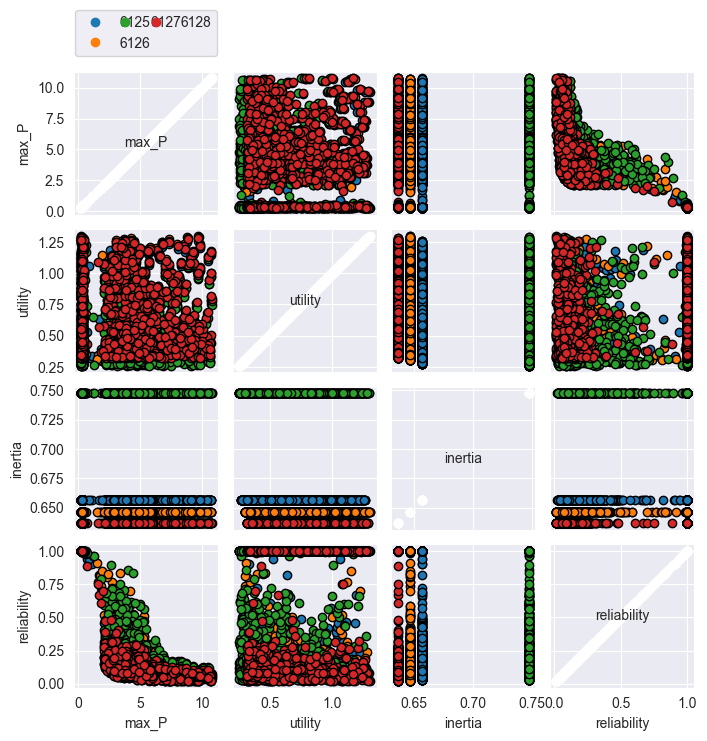

In [34]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by="policy", legend=True)

fig.set_size_inches(8,8)
plt.show()

4. If you have not used parallelization in the foregoing, try to adapt your code to use parallelization. The workbench comes with two evaluators for parallelization. The `MultiProcessingingEvaluator` and the `IpyparallelEvaluator`. When can you use each? Adapt your code from above and sue the `MultiProcessingingEvaluator`. Use the `time` or `timeit` library to check how much faster the computation for 1000 scenarios completes.

#### A note on parallelization in Jupyter notebooks
Using multiprocessing within a Jupyter notebook is tricky. On Linux it will work in general just fine. On a Mac it depends on the version of macOS and the version of Python. If you are on the latest version of macOS in combination with Python 3.8, it might work but no guarantees. On older versions of Python it should work fine. On Windows it is always a problem.

The underlying explanation is quite technical. It has to do with how your operating system creates the additional python processes. On Windows, and the latest version of macOS in combination with Python 3.8. A completely new Python process is spawned. This new process does **not** inherit what is defined in memory of the parent process. The new child process will try to replicate what is in memory of the parent process by executing many of the import statements that have also been executed within the python process. Thus, if you define a model in the main process, it is not guaranteed to be known in the child processes. This is in particular true if you define the model within a jupyter notebook. Then the child processes will **never** know this function. Within jupyter notebooks, therefore, the best practice is to define your model within a `.py` file and import this `.py` file into the notebook. Now, each of the child processes will also execute this import statement and thus know the function.


In [36]:
# Hint: A great moment to take another look at the examples!
from ema_workbench import MultiprocessingEvaluator

with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000, policies=4)

[MainProcess/INFO] pool started with 7 workers
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
 15%|█████▋                               | 616/4000 [00:00<00:02, 1576.09it/s]

[0.         0.06870432 0.16997528 0.19719236 0.22327836 0.29447534
 0.35497811 0.38314314 0.39419054 0.45120205 0.46422623 0.47359643
 0.54774219 0.58291886 0.6604112  0.76769797 0.90447332 1.12872141
 1.48306212 1.8767316  2.28661125 2.62169984 2.85971616 2.98288908
 3.06593408 3.17143473 3.2171504  3.24008745 3.27774315 3.32352951
 3.34960698 3.3346526  3.39288755 3.34957284 3.40086637 3.43371195
 3.40587329 3.41054765 3.44618804 3.42453943 3.39886694 3.39111868
 3.39824691 3.43807536 3.3859971  3.3379842  3.39742636 3.34428041
 3.4001916  3.36171625 3.34079604 3.35463289 3.40601031 3.4204578
 3.42592712 3.44124214 3.3966418  3.43378662 3.41616401 3.4216699
 3.38281156 3.33347743 3.31057083 3.28865897 3.33846027 3.35127043
 3.32335814 3.32047767 3.36968363 3.35687649 3.37643754 3.37318478
 3.34353067 3.33983075 3.39794198 3.39749456 3.34402351 3.34501679
 3.40032657 3.42957016 3.43047397 3.38896434 3.35305279 3.39438309
 3.39727709 3.34674173 3.4018054  3.38440194 3.37242385 3.381662

 24%|████████▋                            | 945/4000 [00:00<00:01, 1539.33it/s]

[0.         0.06047961 0.15157213 0.16410531 0.17878925 0.24003328
 0.28513442 0.292766   0.28203106 0.31883126 0.30043597 0.27821511
 0.32243171 0.30211109 0.31413411 0.32023403 0.29770472 0.28917776
 0.30769398 0.29201518 0.3161372  0.34102168 0.35021719 0.31007807
 0.26886067 0.28062396 0.26171738 0.23708908 0.23948666 0.26028715
 0.27078712 0.24583256 0.29467789 0.2503391  0.29546742 0.32939481
 0.30765177 0.31311478 0.35020801 0.33717586 0.31489067 0.305107
 0.30972008 0.34750663 0.3024062  0.25023826 0.30032044 0.24647269
 0.29570716 0.25837285 0.23363568 0.24296001 0.29139181 0.30927213
 0.31962636 0.34067183 0.30416813 0.33984008 0.3279356  0.33511234
 0.29883952 0.24450599 0.21252696 0.18223335 0.22567507 0.23536635
 0.20551862 0.20014837 0.24740215 0.2353078  0.25504386 0.25305076
 0.22412734 0.21910841 0.27589191 0.27875084 0.2281889  0.22663754
 0.28040549 0.31340373 0.32168036 0.28702358 0.25010929 0.2867582
 0.2902992  0.24028272 0.29089276 0.27587003 0.26375551 0.2711357

 36%|████████████▉                       | 1431/4000 [00:00<00:01, 1519.18it/s]

[0.         0.05111176 0.14695656 0.18741877 0.23251623 0.33053552
 0.4434972  0.56272611 0.71879654 1.00604344 1.39362016 1.90135728
 2.51690916 3.03849264 3.52569392 3.93717006 4.2544181  4.52963748
 4.78339833 4.96204885 5.14772122 5.30468929 5.42099697 5.46806298
 5.50221552 5.57612702 5.6086652  5.62658809 5.66290502 5.71155966
 5.74537271 5.74057381 5.80510745 5.77386274 5.82947699 5.87319106
 5.85791624 5.86911485 5.91131852 5.89860146 5.87791027 5.8717215
 5.88010452 5.9202098  5.87395911 5.82450366 5.87654395 5.82371816
 5.87391478 5.83789707 5.81443487 5.82312973 5.872243   5.89101058
 5.90124545 5.92246416 5.88329217 5.92003585 5.90697728 5.9136865
 5.87631672 5.82335295 5.79163189 5.76007136 5.79906278 5.8091513
 5.78075064 5.77296649 5.81844904 5.80898634 5.83025735 5.83059017
 5.80319084 5.79711242 5.85313711 5.85747017 5.80874273 5.80593439
 5.85986274 5.89391906 5.90275491 5.86731213 5.83183913 5.8688535
 5.87300396 5.82412211 5.87405912 5.85910508 5.84791868 5.85563221

 44%|███████████████▋                    | 1742/4000 [00:01<00:01, 1513.70it/s]

[0.         0.0735259  0.12416823 0.16996794 0.15369913 0.13428372
 0.15557815 0.14136045 0.20060215 0.16171927 0.22378847 0.26361924
 0.20530119 0.22507444 0.26765249 0.28093789 0.22920673 0.24548264
 0.23376792 0.25404404 0.23472399 0.20246961 0.16955356 0.19914076
 0.21910689 0.17953581 0.19568356 0.17737139 0.21039916 0.16948
 0.21071574 0.17662397 0.17095642 0.22767816 0.1771459  0.16729249
 0.18400015 0.14991924 0.14141285 0.21040803 0.17578308 0.15315187
 0.20729361 0.22633082 0.25246449 0.22862735 0.21909917 0.26624102
 0.25148156 0.26499796 0.28753088 0.30065068 0.28919907 0.26527108
 0.28256157 0.2246833  0.25004048 0.19586138 0.16543136 0.17208491
 0.16570552 0.2077569  0.23818324 0.27648832 0.29308704 0.30655841
 0.27462236 0.29006753 0.26518281 0.29383559 0.24194378 0.26705361
 0.27159179 0.27410323 0.24746565 0.2724958  0.23870069 0.24662678
 0.23549164 0.18528585 0.1598239  0.21393546 0.19657583 0.15639069
 0.16119073 0.16034274 0.1430065  0.19157021 0.15117424 0.2048962

 51%|██████████████████▍                 | 2052/4000 [00:01<00:01, 1501.83it/s]

[0.         0.06985344 0.12767947 0.1871881  0.18732896 0.18003243
 0.20885695 0.20418943 0.269537   0.24491297 0.31347767 0.37071061
 0.33832303 0.37071496 0.43035856 0.47494317 0.46506663 0.51085746
 0.54409976 0.61870798 0.69282923 0.79668476 0.97258416 1.34081505
 1.89961369 2.48087467 3.06334583 3.53112042 3.96710355 4.2609314
 4.57439407 4.76682035 4.94489242 5.15168484 5.22924031 5.32033214
 5.41860284 5.45319572 5.4980748  5.61017141 5.61647725 5.62445436
 5.70129524 5.74385534 5.79021293 5.78530639 5.78905668 5.84720509
 5.84376628 5.86619639 5.89607974 5.9150908  5.90801755 5.88854523
 5.90916541 5.85390128 5.88023641 5.82733147 5.79537543 5.79740943
 5.78810258 5.82800662 5.85975415 5.90109279 5.92132117 5.93756367
 5.90740287 5.92425446 5.90121232 5.93186297 5.88017005 5.90466941
 5.90952029 5.91275591 5.88668676 5.91157625 5.87775173 5.8846647
 5.87292168 5.822068   5.79224537 5.84095139 5.82357036 5.78237186
 5.78245119 5.77824477 5.75703756 5.8014364  5.76279151 5.813131

 62%|██████████████████████▌             | 2500/4000 [00:01<00:01, 1468.39it/s]

[0.         0.08514864 0.16400535 0.25738576 0.31830521 0.38986201
 0.52435304 0.69248558 1.01611854 1.4032623  1.98792485 2.61830971
 3.13721437 3.6761869  4.18357032 4.60708663 4.91189857 5.23293687
 5.48500223 5.73024668 5.9058872  6.03877399 6.14449877 6.28779556
 6.40862875 6.4585249  6.54619625 6.58997367 6.67518396 6.68257951
 6.75852398 6.75975948 6.7812424  6.85981932 6.83496154 6.84145015
 6.8702192  6.84877457 6.84680008 6.91991669 6.89707153 6.88070888
 6.93736873 6.96605271 7.00126084 6.98771742 6.98514747 7.03732493
 7.03106963 7.05048364 7.07842785 7.09714741 7.09039233 7.07104381
 7.09096634 7.03633203 7.06142819 7.00814469 6.97304426 6.97308647
 6.96109649 6.99861727 7.02991595 7.07074244 7.09222267 7.11019729
 7.0821064  7.09996115 7.07868099 7.10818996 7.05859155 7.08272248
 7.0885475  7.09268308 7.06695109 7.09107439 7.05935441 7.06560684
 7.05503854 7.00260207 6.97032241 7.0152982  6.99662065 6.95320289
 6.95059098 6.94440363 6.92117535 6.96301646 6.92353921 6.9724

 70%|█████████████████████████▏          | 2797/4000 [00:01<00:00, 1460.49it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[MainProcess/INFO] no time dimension found in results


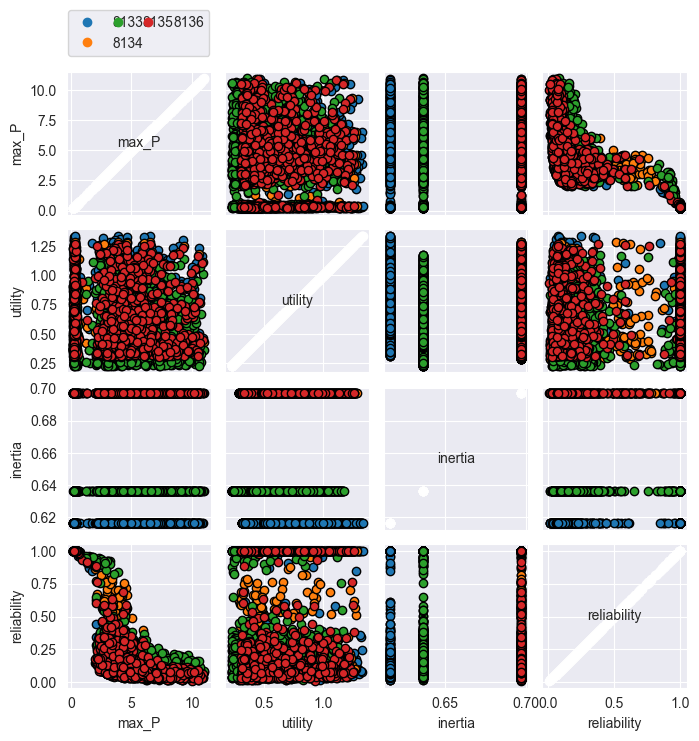

In [37]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by="policy", legend=True)

fig.set_size_inches(8,8)
plt.show()

#### Conclusion
Nice story